# Protein abundance change

This notebook runs the analyses on protein abundance changes between variant and reference alleles using Cell Painting assays

In [16]:
### imports
import os
import polars as pl
import pandas as pd
import numpy as np
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from scipy.stats import ttest_rel, ttest_ind #,shapiro, wilcoxon
sys.path.append("../..")
from img_utils import *
%matplotlib inline

GFP_FEAT = "Cells_Intensity_IntegratedIntensity_GFP" #"Cells_Intensity_MeanIntensity_GFP"

## 1. Load Metadata

### 1.1 Meta allele data

In [2]:
allele_meta_df, img_well_qc_sum_df = pl.DataFrame(), pl.DataFrame()
allele_meta_df_dict, img_well_qc_sum_dict = {}, {}

for bio_rep, bio_rep_batches in BIO_REP_BATCHES_DICT.items():
    for batch_id in bio_rep_batches:
        allele_meta_df_batch = pl.DataFrame()
        platemaps = [file for file in os.listdir(PLATEMAP_DIR.format(batch_id=batch_id)) if file.endswith(".txt")]
        for platemap in platemaps:
            platemap_df = pl.read_csv(os.path.join(PLATEMAP_DIR.format(batch_id=batch_id), platemap), separator="\t", infer_schema_length=100000)
            allele_meta_df_batch = pl.concat([allele_meta_df_batch, 
                                        platemap_df.filter((pl.col("node_type").is_not_null()))], # (~pl.col("node_type").is_in(["TC","NC","PC"]))&
                                        how="diagonal_relaxed").sort("plate_map_name")
            allele_meta_df_batch = allele_meta_df_batch.with_columns(pl.col("plate_map_name").alias("plate_map")) ## str.split('_').list.get(0).
        allele_meta_df = pl.concat([
            allele_meta_df,
            allele_meta_df_batch
        ], how="diagonal_relaxed")#.sort("plate_map_name") ## (~pl.col("node_type").is_in(["TC","NC","PC"]))&
    allele_meta_df_dict[bio_rep] = allele_meta_df_batch

    img_well_qc_sum = pl.read_csv(f"{IMGS_QC_METRICS_DIR}/{bio_rep}/plate-well-level_img_qc_sum.csv")
    img_well_qc_sum_morph = img_well_qc_sum.filter(pl.col("channel")!="GFP")
    img_well_qc_sum_morph = img_well_qc_sum_morph.group_by(["plate","well"]).agg(
        pl.col("is_bg").max().alias("is_bg"),
        pl.col("s2n_ratio").mean().alias("s2n_ratio"),
        pl.col("median_plate").mean().alias("median_plate"),
    ).with_columns(pl.lit("Morph").alias("channel"))
    img_well_qc_sum = pl.concat([
        img_well_qc_sum.select(pl.col(["plate","well","channel","median_plate","is_bg","s2n_ratio"])),
        img_well_qc_sum_morph.select(pl.col(["plate","well","channel","median_plate","is_bg","s2n_ratio"])),
    ], how="vertical_relaxed")
    
    img_well_qc_sum_df = pl.concat(
        [img_well_qc_sum_df, img_well_qc_sum],
        how="diagonal_relaxed"
    )
    img_well_qc_sum_dict[bio_rep] = img_well_qc_sum

## 2. CellProfiler Features

### Get the CP features for cells that passed the QC

In [3]:
pass_qc_prof_dir = "{}/{}/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells.parquet"
cell_alleles = pl.DataFrame()

for bio_rep, bio_rep_batches in BIO_REP_BATCHES_DICT.items():
    combined_profiles_batch = pl.DataFrame()
    for batch_id in bio_rep_batches:
        # Get meta features
        batch_alleles = (
            pl.scan_parquet(
                pass_qc_prof_dir.format(PROF_DIR, batch_id)
            )
            # .filter(pl.col("Metadata_gene_allele").is_in(all_alleles))
            .with_columns(
                pl.concat_str(
                    [
                        "Metadata_Plate",
                        "Metadata_Well",
                        "Metadata_ImageNumber",
                        "Metadata_ObjectNumber",
                    ],
                    separator="_",
                ).alias("Metadata_CellID")
            )
            .select([
                "Metadata_CellID",
                "Metadata_gene_allele",
                "Metadata_Well",
                "Metadata_Plate",
            ])
        )
        combined_profiles_batch = pl.concat([combined_profiles_batch, batch_alleles.collect()]) 
        
    cell_alleles = pl.concat([cell_alleles, combined_profiles_batch])

### Get the Cells_Intensity CP features per all cells

Merge the Cells_Intensity features to the pass-QC cells

In [4]:
combined_gfp_profiles = pl.DataFrame()

for bio_rep, bio_rep_batches in BIO_REP_BATCHES_DICT.items():
    combined_profiles_batch = pl.DataFrame()
    for batch_id in bio_rep_batches:
        # Get meta features
        batch_gfp_prof = (
            pl.scan_parquet(
                f"{PROF_DIR}/{batch_id}/profiles.parquet"
            ).with_columns(
                pl.concat_str(
                    [
                        "Metadata_Plate",
                        "Metadata_Well",
                        "Metadata_ImageNumber",
                        "Metadata_ObjectNumber",
                    ],
                    separator="_",
                ).alias("Metadata_CellID")
            )
        )
        gfp_int = [i for i in batch_gfp_prof.collect_schema().names() if "Cells_Intensity" in i]
        gfp_int = ["Metadata_CellID"] + [i for i in gfp_int if "GFP" in i]
        combined_gfp_profiles = pl.concat([
            combined_gfp_profiles, 
            batch_gfp_prof.select(gfp_int).collect()
        ])

profiles = cell_alleles.join(combined_gfp_profiles, on="Metadata_CellID", how="left")

### Aggregate the cells to well profiles

In [5]:
well_profiles = (
    profiles.group_by(["Metadata_Plate", "Metadata_Well", "Metadata_gene_allele"])
    .agg(
        pl.col(col).median().alias(col)
        for col in profiles.columns
        if not col.startswith("Metadata_")
    )
    # .filter(pl.col("Metadata_gene_allele").is_in(balanced_class_alleles))
    .unique()
)

img_well_qc_sum_gfp = img_well_qc_sum_df.filter(pl.col("channel")=="GFP").with_columns(
    pl.col("plate").alias("Metadata_Plate"),
    pl.col("well").alias("Metadata_Well"),
)

well_profiles = well_profiles.join(
    img_well_qc_sum_gfp,
    on=["Metadata_Plate","Metadata_Well"],
    how="left"
).with_columns(
    pl.col("Metadata_Plate").str.extract(r"(B[^A]*)", 1).replace(BIO_BATCH_MAP_DICT).alias("Metadata_Bio_Batch")
)
print("Original image wells:", well_profiles.shape)

Original image wells: (21078, 25)


In [6]:
well_profiles = well_profiles.filter(~pl.col("is_bg"))
print("Image wells after QC based on GFP:", well_profiles.shape)

Image wells after QC based on GFP: (19558, 25)


In [12]:
# def plot_gfp_per_plate(well_profile_df, gfp_feat="Cells_Intensity_IntegratedIntensity_GFP"):
#     plate_maps = set(["_".join(plate_map.split("_")[:-1]) for plate_map in sorted(well_profile_df["Metadata_Plate"].unique())])
#     for plate_map in plate_maps:
#         plate_map_cc = well_profile_df.filter(pl.col("Metadata_Plate").str.contains(plate_map))
#         plates = sorted(plate_map_cc["Metadata_Plate"].unique().to_list())
#         fig, axes = plt.subplots(2,2,figsize=(48,23)) ## sharey=True,sharex=True
#         for plate in plates:
#             plate_info = plate_map_cc.filter(pl.col("Metadata_Plate")==plate)
#             # display(plate_info.filter(pl.col("is_bg")))
#             # print(plates.index(plate))
#             plot_platemap(
#                 plate_info,
#                 plate,
#                 well_pos_col="Metadata_Well",
#                 # this is the column to color by (categorical or continuous)
#                 value_col=gfp_feat,
#                 # these columns will be concatenated into the annotation text
#                 label_cols=("Metadata_gene_allele",gfp_feat),
#                 ax=axes[plates.index(plate)//2, plates.index(plate)%2],
#                 value_type="continuous",   # or "continuous"
#                 continuous_cmap="vlag",  # matplotlib colormap for continuous mode
#                 grid_square=None
#             )
#         fig.subplots_adjust(wspace=-.55, hspace=.05)
#         plt.tight_layout()
#         plt.show()

# plot_gfp_per_plate(well_profiles)

<Figure size 640x480 with 0 Axes>

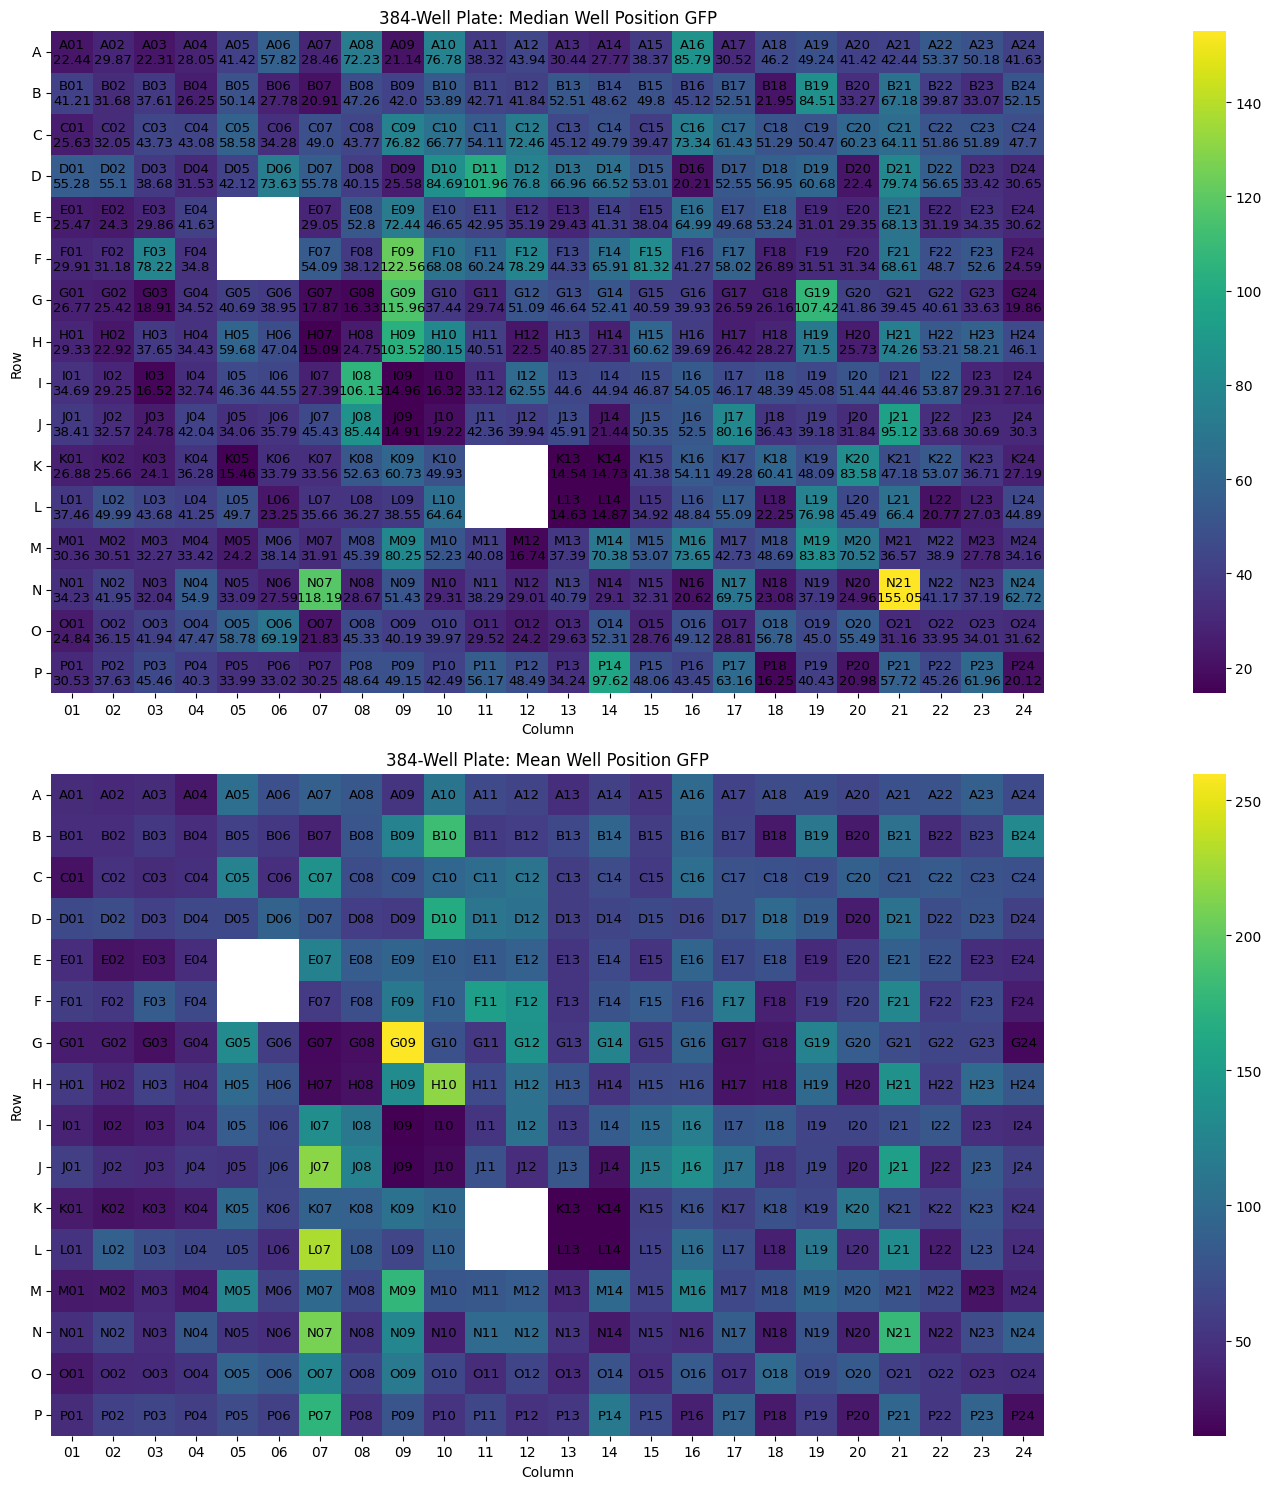

In [13]:
median_well_profile = well_profiles.group_by("Metadata_Well").agg(
    pl.col(GFP_FEAT).median().alias("GFP")
).with_columns(
    pl.col("Metadata_Well").alias("gene_allele")
)
mean_well_profile = well_profiles.group_by("Metadata_Well").agg(
    pl.col(GFP_FEAT).mean().alias("GFP")
).with_columns(
    pl.col("Metadata_Well").alias("gene_allele")
)

plt.clf()
fig, axes = plt.subplots(2,1,figsize=(30,15)) ## sharey=True,sharex=True
plot_platemap(
    median_well_profile,
    "Median Well Position GFP",
    well_pos_col="Metadata_Well",
    # this is the column to color by (categorical or continuous)
    value_col="GFP",
    # these columns will be concatenated into the annotation text
    label_cols=("gene_allele","GFP"),
    ax=axes[0], #[plates.index(plate)//2, plates.index(plate)%2],
    value_type="continuous",   # or "continuous"
    continuous_cmap="viridis",  # matplotlib colormap for continuous mode
    grid_square=None
)
plot_platemap(
    mean_well_profile,
    "Mean Well Position GFP",
    well_pos_col="Metadata_Well",
    # this is the column to color by (categorical or continuous)
    value_col="GFP",
    # these columns will be concatenated into the annotation text
    label_cols=("gene_allele",),
    ax=axes[1], #[plates.index(plate)//2, plates.index(plate)%2],
    value_type="continuous",   # or "continuous"
    continuous_cmap="viridis",  # matplotlib colormap for continuous mode
    grid_square=None
)

fig.subplots_adjust(wspace=-.55, hspace=.05)
plt.tight_layout()
plt.show()

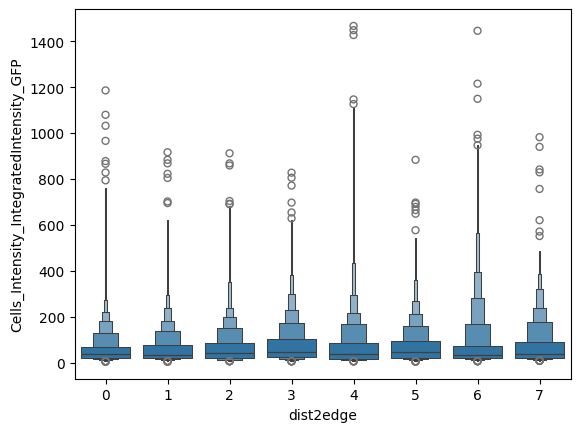

In [14]:
sns.boxenplot(data=well_profiles.with_columns(
    pl.col("Metadata_Well").map_elements(lambda x: well_to_coordinates(x)[1], return_dtype=pl.Int16).alias("well_row"),
    pl.col("Metadata_Well").map_elements(lambda x: well_to_coordinates(x)[2], return_dtype=pl.Int16).alias("well_col")
).with_columns(
    pl.struct(["well_row", "well_col"])
      .map_elements(lambda s: compute_distance(s["well_row"], s["well_col"]), return_dtype=pl.Int16)
      .alias("dist2edge")
).to_pandas(), x="dist2edge", y=GFP_FEAT)
plt.show()

## 3. Calculate abundance hits

Use paired t-test to call abundance hits

In [15]:
tested_variants = allele_meta_df.filter((pl.col("gene_allele").is_not_null())&(pl.col("node_type")=="allele")).unique(subset=["gene_allele"])["gene_allele"]
len(tested_variants)

1808

In [ ]:
## Abundance recalculation test: by Cell MeanIntensity
def paired_ttest(dat, reference: str, var: str, intensity_type: str=GFP_FEAT):
    # pivot to wide: one row per plate
    wide_gfp = dat.pivot(index="Metadata_Plate",
                        columns="Metadata_gene_allele",
                        values=intensity_type)
    # drop any plate that doesn’t have both measurements
    wide_gfp = wide_gfp.dropna(subset=[reference, var])
    if wide_gfp.shape[0] >= 3:
        # now run paired t-test
        t_stat, p_val = ttest_rel(wide_gfp[var].astype(float), wide_gfp[reference].astype(float))
    else:
        t_stat, p_val = None, None

    # ## perform stat test
    # dat = dat.dropna().sort_values(["Metadata_Plate","Metadata_gene_allele"])
    # # Assuming well_abun_stats is a DataFrame with columns 'reference_abundance' and 'variant_abundance'
    # reference_abundance = dat[dat["Metadata_gene_allele"]==reference][intensity_type].values
    # variant_abundance = dat[dat["Metadata_gene_allele"]==var][intensity_type].values
    # t_stat, p_val = ttest_rel(variant_abundance, reference_abundance)
    
    # Calculate Cohen's d
    mean_diff = np.mean(wide_gfp[var]) - np.mean(wide_gfp[reference])
    pooled_std = np.sqrt((np.std(wide_gfp[var], ddof=1) ** 2 + np.std(wide_gfp[reference], ddof=1) ** 2) / 2)
    cohen_d = mean_diff / pooled_std

    summary_df = pl.DataFrame(
        {
            "t_stat": t_stat,
            "p_val": p_val,
            "cohen_d": cohen_d
        }
    )
    summary_df = summary_df.with_columns(
        pl.lit(reference).alias("Gene"), pl.lit(var).alias("Variant")
    )
    return summary_df


def ind_ttest(dat, reference: str, var: str, intensity_type: str=GFP_FEAT):
    ## Per each ref-var well pair on the SAME plate, train and test the classifier
    ## sort the wells to make sure they are from the same plate
    df_sampled = pd.DataFrame()
    for plate in dat["Metadata_Plate"].unique():
        dat = dat[dat["Metadata_Plate"]==plate].dropna().sort_values(["Metadata_gene_allele"])
        # count rows per group
        group_counts = dat.groupby("Metadata_gene_allele").size()
        min_count = group_counts.min()
        # print("Minimum rows in any group:", min_count)
        shuffled = dat.sample(frac=1, random_state=42).reset_index(drop=True)
        # Then take the first min_count rows per group
        sampled_df2 = (
            shuffled
            .groupby("Metadata_gene_allele", group_keys=False)
            .head(min_count)
        )
        df_sampled = pd.concat([df_sampled, sampled_df2])

    # m0 = smf.ols("Cell_count ~ Metadata_Well", data=df_sampled).fit()
    # df_sampled["resid"] = m0.resid
    # print(df_sampled)
    ## require at least two alleles per each VAR and WT group
    if df_sampled.shape[0] >= 4:
        # now run paired t-test
        t_stat, p_val = ttest_ind(
            df_sampled.loc[df_sampled["Metadata_gene_allele"]==allele, intensity_type].astype(float).values,
            df_sampled.loc[df_sampled["Metadata_gene_allele"]==reference, intensity_type].astype(float).values, 
            equal_var=False
        )
        # res_t_stat, res_p_val = ttest_ind(df_sampled.loc[df_sampled["Metadata_gene_allele"]==reference, "resid"].values, 
        #                                   df_sampled.loc[df_sampled["Metadata_gene_allele"]==allele, "resid"].values,
        #                                   equal_var=False)
        # Calculate Cohen's d
        mean_diff = np.mean(df_sampled.loc[df_sampled["Metadata_gene_allele"]==reference, intensity_type].values) - \
                    np.mean(df_sampled.loc[df_sampled["Metadata_gene_allele"]==allele, intensity_type].values)
        pooled_std = np.sqrt((np.std(df_sampled.loc[df_sampled["Metadata_gene_allele"]==allele, intensity_type].values, ddof=1) ** 2 + \
                              np.std(df_sampled.loc[df_sampled["Metadata_gene_allele"]==reference, intensity_type].values, ddof=1) ** 2) / 2)
        cohen_d = mean_diff / pooled_std
    else:
        t_stat, p_val, cohen_d = None, None, None
        # res_t_stat, res_p_val = None, None

    # break
    summary_df = pl.DataFrame(
        {
            "t_stat": t_stat,
            "p_val": p_val,
            "cohen_d": cohen_d
        }
    )
    summary_df = summary_df.with_columns(
        pl.lit(reference).alias("Gene"), pl.lit(var).alias("Variant")
    )
    return summary_df

In [20]:
well_abun_stats = []

for allele in tqdm(well_profiles.select(pl.col("Metadata_gene_allele")).to_pandas()["Metadata_gene_allele"].unique()):
    if allele is None or allele.split("_")[0] == allele or allele not in tested_variants:
        continue

    reference = allele.split("_")[0]
    temp_prof_var = well_profiles.filter(
        (pl.col("Metadata_gene_allele") == allele) | (pl.col("Metadata_gene_allele") == reference)
    ).select(
        pl.col(["Metadata_gene_allele","Metadata_Plate","Metadata_Well",GFP_FEAT,"median_plate","Metadata_Bio_Batch"])
    ).to_pandas()

    ## subtract plate background
    temp_prof_var[GFP_FEAT] = temp_prof_var[GFP_FEAT] - temp_prof_var["median_plate"]

    bio_batch_list = list(temp_prof_var["Metadata_Bio_Batch"].unique())
    # if (len(bio_batch_list) > 1):
    #     print(bio_batch_list)
    #     print(allele)
        # print(temp_prof_var)
    for bio_batch in bio_batch_list:
        temp_prof = temp_prof_var[temp_prof_var["Metadata_Bio_Batch"]==bio_batch]
        if (temp_prof["Metadata_gene_allele"].unique().shape[0] < 2):
            # print(temp_prof)
            continue

        var_profiles = temp_prof[temp_prof["Metadata_gene_allele"]==allele]
        ref_profiles = temp_prof[(temp_prof["Metadata_gene_allele"]==reference)&(temp_prof["Metadata_Plate"].isin(var_profiles["Metadata_Plate"].unique()))]
        temp_prof = pd.concat([var_profiles, ref_profiles])

        if (bio_batch == "B_11-12"):
            ind_t_res = ind_ttest(
                dat=temp_prof,
                reference=reference,
                var=allele
            ).with_columns(
                pl.lit("").alias("Ref_well"),
                pl.lit("").alias("Var_well"),
                pl.lit(bio_batch).alias("Bio_Batch")
            )
            well_abun_stats.append(
                ind_t_res
            )
        else:
            ref_wells = ref_profiles["Metadata_Well"].unique()
            var_wells = var_profiles["Metadata_Well"].unique()
            ref_var_pairs = [(ref_well, var_well) for ref_well in ref_wells for var_well in var_wells]
            # display(temp_prof)
            
            ## Per each ref-var well pair on the SAME plate, train and test the classifier
            for ref_var in ref_var_pairs:
                ## sort the wells to make sure they are from the same plate
                df_sampled = temp_prof[temp_prof["Metadata_Well"].isin(ref_var)].dropna().sort_values(["Metadata_Plate","Metadata_gene_allele"])
                # display(df_sampled)
                paired_t_res = paired_ttest(
                    dat=df_sampled,
                    reference=reference,
                    var=allele
                ).with_columns(
                    pl.lit(ref_var[0]).alias("Ref_well"),
                    pl.lit(ref_var[1]).alias("Var_well"),
                    pl.lit(bio_batch).alias("Bio_Batch")
                )
                well_abun_stats.append(
                    paired_t_res
                )

well_abun_stats = pl.concat(well_abun_stats, how="vertical")
well_abun_stats = well_abun_stats.rename({"t_stat": "U2OS_t"})
well_abun_stats = well_abun_stats.sort(["Gene", "Variant", "U2OS_t", "p_val", "cohen_d"])
well_abun_stats

100%|██████████| 2052/2052 [00:17<00:00, 116.98it/s]


U2OS_t,p_val,cohen_d,Gene,Variant,Ref_well,Var_well,Bio_Batch
f64,f64,f64,str,str,str,str,str
1.732321,0.12682,0.716809,"""ABCD1""","""ABCD1_Arg389Gly""","""A01""","""E01""","""B_13-14"""
0.280926,0.786889,0.092501,"""ABCD1""","""ABCD1_Arg518Gln""","""A01""","""G01""","""B_13-14"""
-2.977011,0.020602,-0.89755,"""ABCD1""","""ABCD1_Arg518Trp""","""A01""","""C01""","""B_13-14"""
-8.730737,0.000052,-0.639137,"""ADIPOR1""","""ADIPOR1_Tyr353Cys""","""A01""","""C01""","""B_18-19"""
-3.538794,0.009485,-0.2865,"""ADIPOR2""","""ADIPOR2_Ser381Asn""","""E01""","""G01""","""B_18-19"""
…,…,…,…,…,…,…,…
2.164444,0.067166,1.307646,"""ZC4H2""","""ZC4H2_Pro201Ser""","""I06""","""A08""","""B_13-14"""
5.151696,0.001322,1.831257,"""ZC4H2""","""ZC4H2_Pro201Ser""","""I06""","""K06""","""B_13-14"""
-9.774373,0.000025,-5.162232,"""ZC4H2""","""ZC4H2_Val63Leu""","""I06""","""M06""","""B_13-14"""


## 3. Summarize Results

In [22]:
## drop the null alleles
well_abun_stats = well_abun_stats.filter(
    pl.col("Gene")!="CCM2",
    pl.col("Bio_Batch")!="B_18-19",
    pl.col("U2OS_t").is_not_null()
)

## extract the alleles with only single appearance
variants_single = well_abun_stats.group_by("Variant").len().filter(pl.col("len")==1)["Variant"]
well_abun_stats_single = well_abun_stats.filter(pl.col("Variant").is_in(variants_single))

## extract the alleles with replicates
variants_replicate = well_abun_stats.group_by("Variant").len().filter(pl.col("len")>1).unique(subset="Variant")["Variant"]
well_abun_stats_rep = well_abun_stats.filter(pl.col("Variant").is_in(variants_replicate))

## check the consistency between replicates
well_abun_stats_rep_group = well_abun_stats_rep.group_by("Variant").agg(
    pl.len().alias("count"),
    (pl.col("U2OS_t")<0).sum().alias("desc"),
    (pl.col("U2OS_t")>0).sum().alias("incr")
)
inconsistent_alleles = well_abun_stats_rep_group.filter((pl.col("count")!=pl.col("desc"))&(pl.col("count")!=pl.col("incr")))["Variant"].unique()
display(well_abun_stats_rep_group.filter((pl.col("count")!=pl.col("desc"))&(pl.col("count")!=pl.col("incr"))))

## No problem them merge by mean
well_abun_stats_rep = well_abun_stats_rep.group_by(["Gene","Variant"]).agg(
    pl.col("U2OS_t").mean().alias("U2OS_t"),
    pl.col("p_val").mean().alias("p_val")
).with_columns(
    pl.when(pl.col("Variant").is_in(inconsistent_alleles))
    .then(pl.lit(1))
    .otherwise(pl.col("p_val"))
    .alias("manual_adj_pval")
)

Variant,count,desc,incr
str,u32,u32,u32
"""RAF1_Phe22Leu""",3,1,2
"""SDHD_Ser68Gly""",2,1,1
"""GRN_Ala324Thr""",2,1,1
"""SMAD3_Thr261Ile""",2,1,1
"""SDHD_Ala90Val""",2,1,1
…,…,…,…
"""FARS2_Asp142Tyr""",2,1,1
"""RAF1_Asp381Asn""",3,1,2
"""KRT6A_Thr552Ser""",2,1,1


In [23]:
well_abun_stats_final = pl.concat([
    well_abun_stats_rep,
    well_abun_stats_single.with_columns(
        pl.col("p_val").alias("manual_adj_pval")
    ).select(pl.col(well_abun_stats_rep.columns))
])

well_abun_stats_final = well_abun_stats_final.rename({"U2OS_t": "U2OS_prot_abun_t_stat", "manual_adj_pval": "U2OS_prot_abun_t_pval"})
well_abun_stats_final = well_abun_stats_final.select(["Gene", "Variant", "U2OS_prot_abun_t_stat", "U2OS_prot_abun_t_pval"]) ## , "U2OS_paired_tstat_edgedist_resid", "U2OS_t_edgedist_resid_pval",

In [24]:
# Total number of increase vs. decrease
total = well_abun_stats_final.shape[0]

## We are comparing REF - VAR in the paired_ttest ttest_rel
## The t-statistic is calculated as np.mean(a - b)/se, where se is the standard error.
## Thus, t-stat > 0 means REF more than VAR --> VAR decreasing CC
per_dec = well_abun_stats_final.filter(pl.col("U2OS_prot_abun_t_stat") < 0).shape[0]
per_inc = well_abun_stats_final.filter(pl.col("U2OS_prot_abun_t_stat") > 0).shape[0]

print("Total decreasin vs increasing percent:")
print(f"{per_dec} {per_dec / total * 100:.2f} %")
print(f"{per_inc} {per_inc / total * 100:.2f} %")

dec_sig = well_abun_stats_final.filter(pl.col("U2OS_prot_abun_t_pval") < 0.05).filter(pl.col("U2OS_prot_abun_t_stat") < 0).shape[0]
inc_sig = well_abun_stats_final.filter(pl.col("U2OS_prot_abun_t_pval") < 0.05).filter(pl.col("U2OS_prot_abun_t_stat") > 0).shape[0]

print("Number sig decreases")
print(dec_sig)
print("Number sig increases")
print(inc_sig)

Total decreasin vs increasing percent:
506 49.71 %
512 50.29 %
Number sig decreases
335
Number sig increases
302


In [26]:
well_abun_stats_final.sort(by="U2OS_prot_abun_t_pval", descending=True)

Gene,Variant,U2OS_prot_abun_t_stat,U2OS_prot_abun_t_pval
str,str,f64,f64
"""SDHD""","""SDHD_His102Pro""",0.475944,1.0
"""BRIP1""","""BRIP1_Val76Ile""",-0.150193,1.0
"""SDHD""","""SDHD_Ala90Glu""",-0.886733,1.0
"""GRN""","""GRN_Ser120Tyr""",0.717022,1.0
"""FARS2""","""FARS2_Ser57Cys""",-0.687243,1.0
…,…,…,…
"""APOA1""","""APOA1_Leu114Pro""",-18.958214,2.8257e-7
"""RNF135""","""RNF135_Arg286His""",25.371617,2.4697e-7
"""GFAP""","""GFAP_Lys236Thr""",21.038334,1.3788e-7


In [27]:
well_abun_stats_final.write_csv(f"{CC_ABUND_DIR}/prot_abundance_diff_summary.csv")

## 4. Visualize Imaging Wells

In [30]:
OUT_IMGS_DIR = ""
from display_img import *

<Figure size 640x480 with 0 Axes>

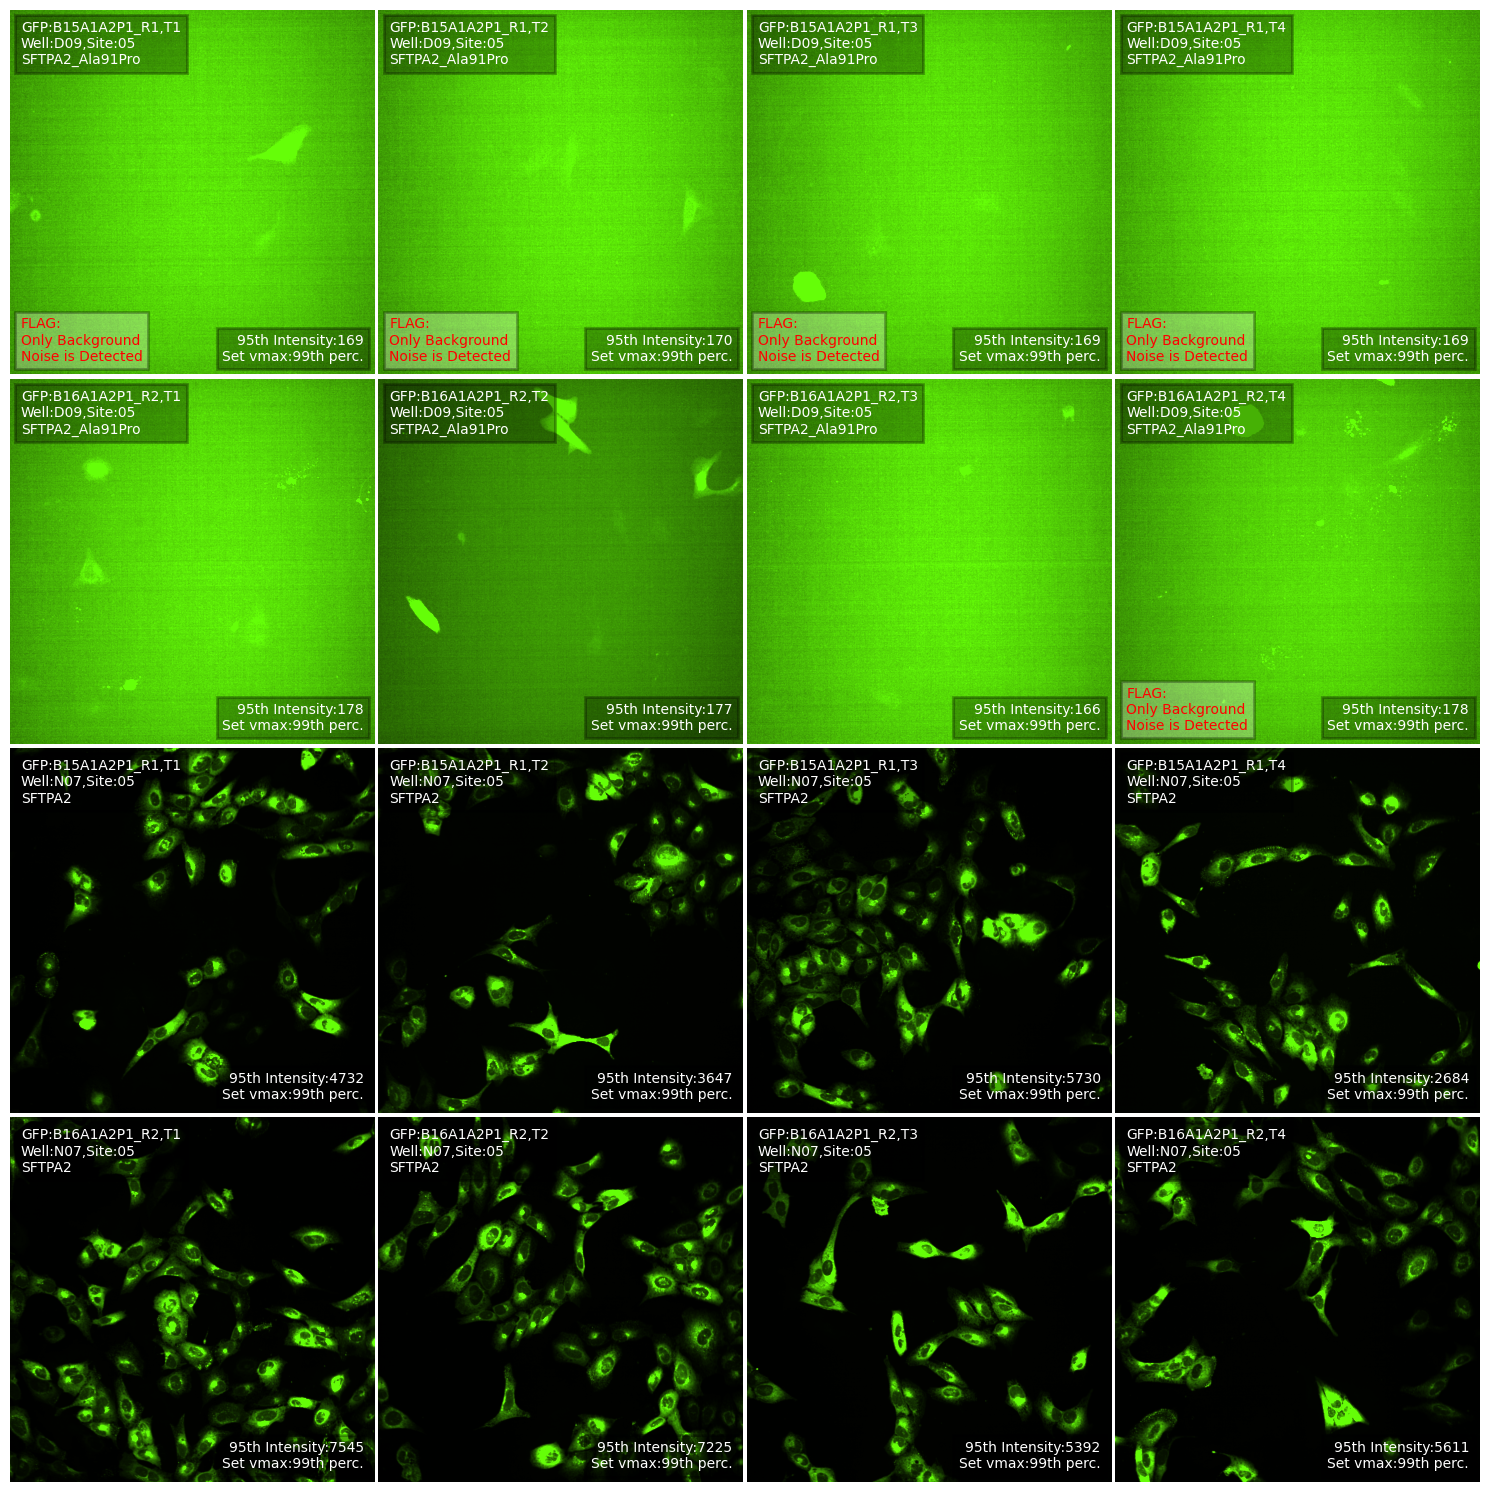

In [31]:
plot_allele(allele_meta_df_dict["2025_03_Batch_15-16"], "SFTPA2_Ala91Pro", "GFP", 
            plate_img_qc=img_well_qc_sum_dict["2025_03_Batch_15-16"],
            site="05", max_intensity=0.99, display=True, imgs_dir=TIFF_IMGS_DIR)

## 5. Test Abundance Hits between Ctrl Wells

In [25]:
from itertools import combinations

ctrl_alleles = allele_meta_df.filter((pl.col("gene_allele").is_not_null())&(pl.col("node_type").is_in(["NC","PC"]))).unique(subset=["gene_allele"])["gene_allele"]

In [54]:
well_abun_stats_ctrls = []

for allele in tqdm(well_profiles.select(pl.col("Metadata_gene_allele")).to_pandas()["Metadata_gene_allele"].unique()):
    if allele is None or allele not in ctrl_alleles:
        continue

    temp_prof_var = well_profiles.filter(
        (pl.col("Metadata_gene_allele") == allele)
    ).select(
        pl.col(["Metadata_gene_allele","Metadata_Plate","Metadata_Well",GFP_FEAT,"median_plate","Metadata_Bio_Batch"])
    ).to_pandas()

    ## subtract plate background
    temp_prof_var[GFP_FEAT] = temp_prof_var[GFP_FEAT] - temp_prof_var["median_plate"]
    # display(temp_prof_var)

    bio_batch_list = list(temp_prof_var["Metadata_Bio_Batch"].unique())
    # if (len(bio_batch_list) > 1):
    #     print(bio_batch_list)
    #     print(allele)
        # print(temp_prof_var)
    for bio_batch in bio_batch_list:
        temp_prof_batch = temp_prof_var[temp_prof_var["Metadata_Bio_Batch"]==bio_batch]
        plate_list = set([plate.split("T")[0] for plate in list(temp_prof_batch["Metadata_Plate"].unique())])
        # print(plate_list)
        for plate in plate_list:
            temp_prof = temp_prof_batch[temp_prof_batch["Metadata_Plate"].str.contains(plate)]
            # print(temp_prof)

            wells = list(temp_prof["Metadata_Well"].unique())
            # ref_wells = ref_profiles["Metadata_Well"].unique()
            # var_wells = var_profiles["Metadata_Well"].unique()
            ref_var_pairs = list(combinations(wells, 2))
            
            ## Per each ref-var well pair on the SAME plate, train and test the classifier
            for ref_var in ref_var_pairs:
                ## sort the wells to make sure they are from the same plate
                df_sampled = temp_prof[temp_prof["Metadata_Well"].isin(ref_var)].dropna().sort_values(["Metadata_Plate","Metadata_gene_allele"])
                paired_t_res = paired_ttest_ctrl(
                    dat=df_sampled
                ).with_columns(
                    pl.lit(plate).alias("Plate_map"),
                    pl.lit(bio_batch).alias("Bio_Batch"),
                    pl.lit(allele).alias("Ctrl_Allele")
                )
                well_abun_stats_ctrls.append(
                    paired_t_res
                )

well_abun_stats_ctrl_df = pl.concat(well_abun_stats_ctrls, how="vertical")
# well_abun_stats = well_abun_stats.rename({"t_stat": "U2OS_t"})
# well_abun_stats = well_abun_stats.sort(["Gene", "Variant", "U2OS_t", "p_val", "cohen_d"])
# well_abun_stats

100%|██████████| 2052/2052 [00:02<00:00, 779.33it/s] 


In [55]:
# well_abun_stats_ctrl_df.filter(pl.col("Ctrl_Allele")=="PRKACB").sort("Bio_Batch")

well_abun_stats_ctrl_df.filter(pl.col("p_val")<0.05).sort("Bio_Batch")

t_stat,p_val,cohen_d,Well_0,Well_1,Plate_map,Bio_Batch,Ctrl_Allele
f64,f64,f64,str,str,str,str,str
4.728763,0.017922,1.527293,"""I10""","""J10""","""2025_01_28_B14A7A8P2_""","""B_13-14""","""ALK_Arg1275Gln"""
15.10165,0.004356,5.86159,"""I09""","""I10""","""2025_01_28_B14A7A8P2_""","""B_13-14""","""ALK_Arg1275Gln"""
-17.828295,0.000385,-4.89443,"""I10""","""J09""","""2025_01_28_B14A7A8P2_""","""B_13-14""","""ALK_Arg1275Gln"""
11.050309,0.00809,5.547735,"""I09""","""J10""","""2025_01_28_B14A7A8P2_""","""B_13-14""","""ALK_Arg1275Gln"""
13.915495,0.000803,5.793996,"""J09""","""J10""","""2025_01_28_B14A7A8P2_""","""B_13-14""","""ALK_Arg1275Gln"""
…,…,…,…,…,…,…,…
-5.857983,0.027926,-0.636939,"""J15""","""I15""","""2024_02_02_B8A1R2_P3""","""B_7-8""","""RHEB"""
-5.855571,0.027948,-1.980269,"""I16""","""I15""","""2024_01_19_B7A1R1_P3""","""B_7-8""","""RHEB"""
11.17628,0.007911,1.398459,"""L13""","""L14""","""2024_02_01_B8A1R2_P2""","""B_7-8""","""MAPK9"""


In [29]:
## Abundance recalculation test: by Cell MeanIntensity
def paired_ttest_ctrl(dat, intensity_type: str=GFP_FEAT):
    wells_pair = dat["Metadata_Well"].unique()
    # pivot to wide: one row per plate
    wide_gfp = dat.pivot(index="Metadata_Plate",
                        columns="Metadata_Well",
                        values=intensity_type)
    
    # drop any plate that doesn’t have both measurements
    wide_gfp = wide_gfp.dropna(subset=[wells_pair[0], wells_pair[1]])
    if wide_gfp.shape[0] >= 3:
        # now run paired t-test
        t_stat, p_val = ttest_rel(wide_gfp[wells_pair[0]].astype(float), wide_gfp[wells_pair[1]].astype(float))
    else:
        t_stat, p_val = None, None

    # ## perform stat test
    # dat = dat.dropna().sort_values(["Metadata_Plate","Metadata_gene_allele"])
    # # Assuming well_abun_stats is a DataFrame with columns 'reference_abundance' and 'variant_abundance'
    # reference_abundance = dat[dat["Metadata_gene_allele"]==reference][intensity_type].values
    # variant_abundance = dat[dat["Metadata_gene_allele"]==var][intensity_type].values
    # t_stat, p_val = ttest_rel(variant_abundance, reference_abundance)
    
    # Calculate Cohen's d
    mean_diff = np.mean(wide_gfp[wells_pair[0]]) - np.mean(wide_gfp[wells_pair[1]])
    pooled_std = np.sqrt((np.std(wide_gfp[wells_pair[0]], ddof=1) ** 2 + np.std(wide_gfp[wells_pair[1]], ddof=1) ** 2) / 2)
    cohen_d = mean_diff / pooled_std

    summary_df = pl.DataFrame(
        {
            "t_stat": t_stat,
            "p_val": p_val,
            "cohen_d": cohen_d
        }
    )
    summary_df = summary_df.with_columns(
        pl.lit(wells_pair[1]).alias("Well_0"), pl.lit(wells_pair[0]).alias("Well_1")
    )
    return summary_df